# Comparative Analysis
In this notebook, we compare ClaSS with different competitors regarding scalability.

In [1]:
import matplotlib

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [1]:
import numpy as np

import pandas as pd

pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()
sns.set_color_codes()

import sys

sys.path.append("../")

In [2]:
from src.utils import load_combined_dataset
from src.clazz.window_size import suss

Let's choose a score for evaluation (F1 or Covering).

In [3]:
eval_score = "covering_score"

In [4]:
df_comb = load_combined_dataset()
df_comb['period_size'] = df_comb['window_size']
df_comb['window_size'] = df_comb.time_series.apply(lambda ts: np.int64(suss(ts[:10_000])))
df_comb['ts_len'] = df_comb.time_series.apply(len)
# takes too much space
df_comb.drop("time_series", axis=1, inplace=True)
df_comb.head()

,name,window_size,change_points,period_size,ts_len
0,Adiac,22,"[572, 1012, 1232]",10,1408
1,ArrowHead,32,[753],10,1506
2,Beef,66,[705],50,1410
3,BeetleFly,34,[1280],10,2560
4,BirdChicken,48,[1280],20,2560


Let's load the scores from the different methods.

In [5]:
df_runtimes = pd.read_csv("../experiments/runtimes.csv")
df_throughput = pd.read_csv("../experiments/throughputs.csv")
df_scores = pd.read_csv("../experiments/scores.csv")

df_runtimes.sort_values(by="dataset", inplace=True)
df_throughput.sort_values(by="dataset", inplace=True)
df_scores.sort_values(by="dataset", inplace=True)

idx_sizes = np.argsort(df_comb.ts_len).to_numpy()
df_runtimes

,name,dataset,ClaSS,FLOSS,Window,ADWIN,DDM,HDDM,ChangeFinder,NEWMA
32,TSSB,Adiac,0.40610,1.01874,0.36383,0.10162,0.07731,0.08492,0.67245,0.11260
33,TSSB,ArrowHead,0.47278,11.13843,0.38538,0.13435,0.08320,0.08602,0.71661,0.14137
34,TSSB,Beef,2.38714,1.19796,0.30420,0.12322,0.08852,0.08530,0.68239,0.11038
35,TSSB,BeetleFly,2.77209,11.02755,0.69739,0.22941,0.13117,0.15063,1.22102,0.19440
36,TSSB,BirdChicken,2.72324,1.30108,0.66402,0.22486,0.13203,0.14784,1.20213,0.19555
38,TSSB,CBF,0.26950,1.17511,0.24103,0.08732,0.05563,0.07487,0.37858,0.07849
0,UTSA,Cane,14.74109,11.79066,1.59219,0.46415,0.25494,0.27347,2.33889,0.39344
37,TSSB,Car,0.63019,10.96357,0.55627,0.15737,0.09345,0.11493,1.01801,0.16883
101,TSSB,Chinatown,0.05150,1.10076,0.03957,0.01724,0.00997,0.01138,0.11131,0.01707
39,TSSB,ChlorineConcentration,4.99785,1.88549,1.99077,0.55915,0.38868,0.39559,3.26612,0.56877


Let's calculate the sum/mean/std score.

In [6]:
np.round(((df_runtimes.iloc[:, 2:].sum(axis=0) / 60) / 60).sort_values(ascending=False), 0)

FLOSS           1109.0
ClaSS            109.0
Window            52.0
ChangeFinder      45.0
ADWIN             10.0
NEWMA              7.0
DDM                5.0
HDDM               4.0
dtype: float64

In [7]:
np.round(df_scores.mean(), 3)

/var/folders/1m/8xt9fm8d1575s4p3vrgccf7r0000gn/T/ipykernel_2934/3037999765.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  np.round(df_scores.mean(), 3)


ClaSS           0.569
FLOSS           0.386
Window          0.322
ADWIN           0.284
DDM             0.311
HDDM            0.267
ChangeFinder    0.432
NEWMA           0.254
dtype: float64

In [8]:
np.round(df_throughput.mean(axis=0).sort_values(), 0)

/var/folders/1m/8xt9fm8d1575s4p3vrgccf7r0000gn/T/ipykernel_2934/817539412.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  np.round(df_throughput.mean(axis=0).sort_values(), 0)


FLOSS             378.0
ClaSS            1408.0
ChangeFinder     2703.0
Window           2991.0
ADWIN           12958.0
NEWMA           15949.0
DDM             26031.0
HDDM            26458.0
dtype: float64

In [10]:
np.round(df_throughput.iloc[:,2:].std(axis=0).sort_values(), 0)

ChangeFinder     639.0
ClaSS            666.0
FLOSS            787.0
Window           798.0
ADWIN           1203.0
NEWMA           1471.0
DDM             3648.0
HDDM            4066.0
dtype: float64

In [9]:
np.round(df_throughput.iloc[:,2:].max(axis=0).sort_values(), 0)

ClaSS            4660.0
FLOSS            4954.0
Window           6065.0
ChangeFinder     7691.0
ADWIN           16684.0
NEWMA           18946.0
DDM             33158.0
HDDM            33170.0
dtype: float64

Let's plot some relationships.

/var/folders/1m/8xt9fm8d1575s4p3vrgccf7r0000gn/T/ipykernel_1859/3871166872.py:8: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(fontsize)
/var/folders/1m/8xt9fm8d1575s4p3vrgccf7r0000gn/T/ipykernel_1859/3871166872.py:11: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(fontsize)


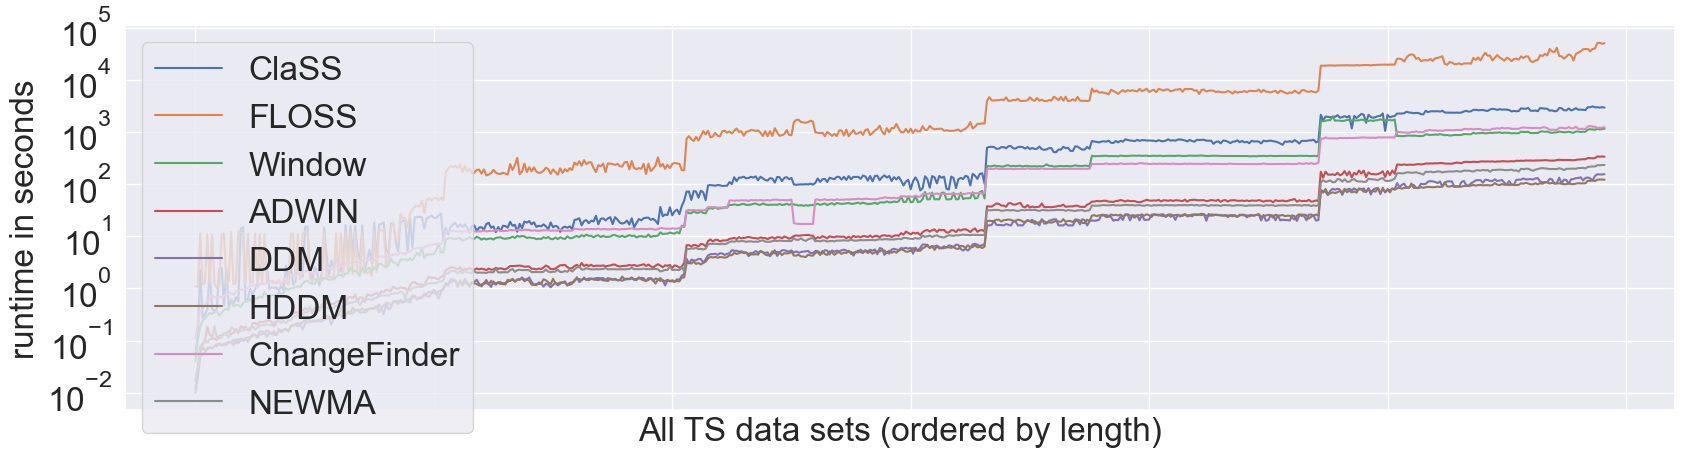

In [11]:
fontsize = 24
_, ax = plt.subplots(1, figsize=(20, 5))

for name in df_runtimes.columns[2:]:
    ax.plot(df_runtimes[name].to_numpy()[idx_sizes], label=name)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(fontsize)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(fontsize)

ax.tick_params(
    axis='x',
    which='both',
    labelbottom=False,
    labelleft=False
)
ax.legend(loc=2, prop={'size': fontsize})
ax.set_xlabel("All TS data sets (ordered by length)", fontsize=fontsize)
ax.set_ylabel("runtime in seconds", fontsize=fontsize)

ax.set_yscale('log')

names = df_runtimes.name.to_numpy().tolist()
names = np.array(names)[idx_sizes]

plt.savefig(f"../figures/runtime.pdf", bbox_inches="tight")

/var/folders/1m/8xt9fm8d1575s4p3vrgccf7r0000gn/T/ipykernel_1859/3670150135.py:18: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(fontsize)
/var/folders/1m/8xt9fm8d1575s4p3vrgccf7r0000gn/T/ipykernel_1859/3670150135.py:21: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(fontsize)


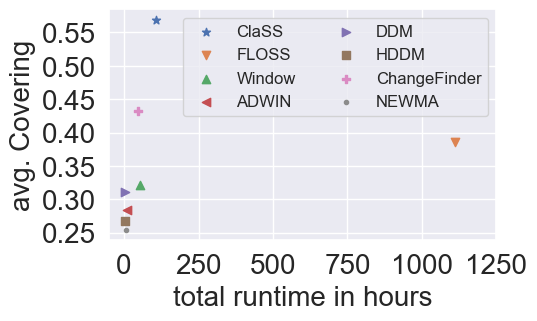

In [12]:
fontsize = 20

_, ax = plt.subplots(1, figsize=(5, 3))

markers = ["*", "v", "^", "<", ">", "s", "P", "."]

for competitor, marker in zip(df_runtimes.columns[2:], markers):
    ax.scatter(((df_runtimes[competitor].sum() / 60) / 60), df_scores[competitor].mean(), label=competitor, marker=marker)

ax.set_xlabel("total runtime in hours", fontsize=fontsize)
ax.set_ylabel("avg. Covering", fontsize=fontsize)

ax.legend(prop={'size': 12}, ncol=2, loc=1)

ax.set_xticks(np.arange(0, 1400, 250))

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(fontsize)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(fontsize)

plt.savefig(f"../figures/runtime_covering.pdf", bbox_inches="tight")

In [13]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression().fit(df_comb.ts_len.to_numpy().reshape(-1, 1), df_runtimes.ClaSS.to_numpy().reshape(-1, 1))
y_min, y_max = lr.predict(np.array([df_comb.ts_len.min(), df_comb.ts_len.max()]).reshape(-1, 1)).flatten()

# mean deviation predicted / actual ts length
np.mean(np.abs(1 - lr.predict(df_comb.ts_len.to_numpy().reshape(-1, 1)).flatten() / df_runtimes.ClaSS.to_numpy()))

4.920453700680932

/var/folders/1m/8xt9fm8d1575s4p3vrgccf7r0000gn/T/ipykernel_1859/2931162131.py:12: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(fontsize)
/var/folders/1m/8xt9fm8d1575s4p3vrgccf7r0000gn/T/ipykernel_1859/2931162131.py:15: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(fontsize)


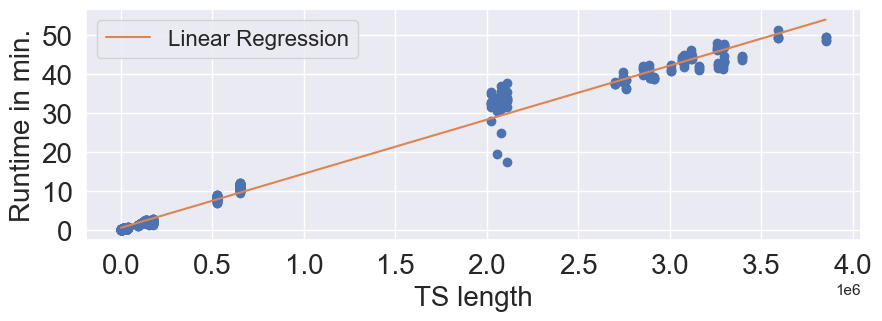

In [14]:
fontsize = 20

_, ax = plt.subplots(1, figsize=(10, 3))
ax.scatter(df_comb.ts_len, df_runtimes.ClaSS / 60)

ax.plot([df_comb.ts_len.min(), df_comb.ts_len.max()], [y_min / 60, y_max / 60], c="C1", label="Linear Regression")

ax.set_xlabel("TS length", fontsize=fontsize)
ax.set_ylabel("Runtime in min.", fontsize=fontsize)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(fontsize)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(fontsize)

ax.legend(loc=2, prop={'size': fontsize - 4})

plt.savefig(f"../figures/runtime_length_line.pdf", bbox_inches="tight")

/var/folders/1m/8xt9fm8d1575s4p3vrgccf7r0000gn/T/ipykernel_1859/87260970.py:10: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(fontsize)
/var/folders/1m/8xt9fm8d1575s4p3vrgccf7r0000gn/T/ipykernel_1859/87260970.py:13: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(fontsize)


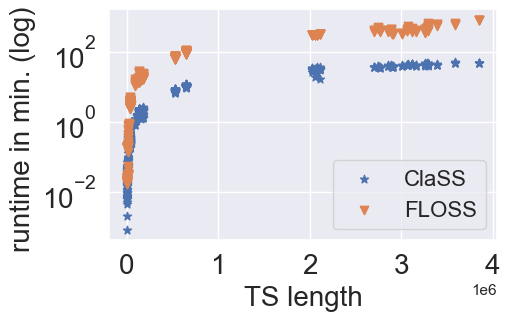

In [15]:
fontsize = 20

_, ax = plt.subplots(1, figsize=(5, 3))
ax.scatter(df_comb.ts_len, df_runtimes.ClaSS / 60, label="ClaSS", marker="*")
ax.scatter(df_comb.ts_len, df_runtimes.FLOSS / 60, label="FLOSS", marker="v")
ax.set_xlabel("TS length", fontsize=fontsize)
ax.set_ylabel("runtime in min. (log) ", fontsize=fontsize)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(fontsize)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(fontsize)

ax.set_yscale('log')
ax.legend(loc=4, prop={'size': fontsize - 4})

plt.savefig(f"../figures/runtime_length.pdf", bbox_inches="tight")

/var/folders/1m/8xt9fm8d1575s4p3vrgccf7r0000gn/T/ipykernel_1859/1459560774.py:10: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(fontsize)
/var/folders/1m/8xt9fm8d1575s4p3vrgccf7r0000gn/T/ipykernel_1859/1459560774.py:13: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(fontsize)


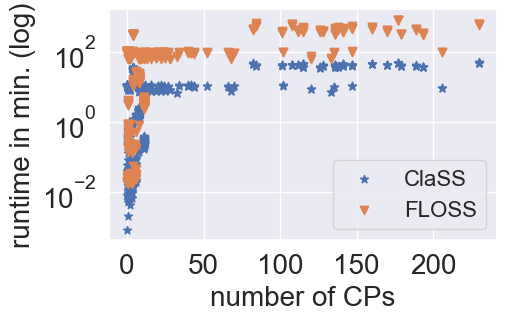

In [16]:
fontsize = 20

_, ax = plt.subplots(1, figsize=(5, 3))
ax.scatter(df_comb["change_points"].apply(len), df_runtimes.ClaSS / 60, label="ClaSS", marker="*")
ax.scatter(df_comb["change_points"].apply(len), df_runtimes.FLOSS / 60, label="FLOSS", marker="v")
ax.set_xlabel("number of CPs", fontsize=fontsize)
ax.set_ylabel("runtime in min. (log)", fontsize=fontsize)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(fontsize)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(fontsize)

ax.set_yscale('log')
ax.legend(loc=4, prop={'size': fontsize - 4})

plt.savefig(f"../figures/runtime_cps.pdf", bbox_inches="tight")

/var/folders/1m/8xt9fm8d1575s4p3vrgccf7r0000gn/T/ipykernel_1859/4256172336.py:10: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(fontsize)
/var/folders/1m/8xt9fm8d1575s4p3vrgccf7r0000gn/T/ipykernel_1859/4256172336.py:13: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(fontsize)


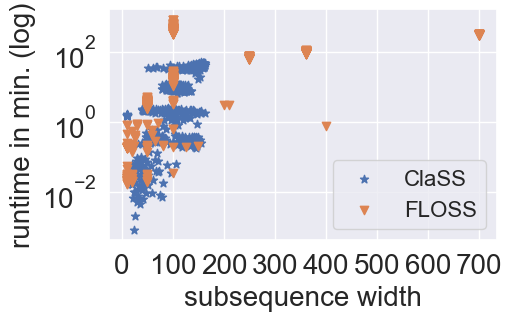

In [17]:
fontsize = 20

_, ax = plt.subplots(1, figsize=(5, 3))
ax.scatter(df_comb.window_size, df_runtimes.ClaSS / 60, label="ClaSS", marker="*")
ax.scatter(df_comb.period_size, df_runtimes.FLOSS / 60, label="FLOSS", marker="v")
ax.set_xlabel("subsequence width", fontsize=fontsize)
ax.set_ylabel("runtime in min. (log)", fontsize=fontsize)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(fontsize)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(fontsize)
    
ax.set_yscale('log')
ax.legend(loc=4, prop={'size': fontsize - 4})

plt.savefig(f"../figures/runtime_window.pdf", bbox_inches="tight")

/var/folders/1m/8xt9fm8d1575s4p3vrgccf7r0000gn/T/ipykernel_1859/3715148413.py:10: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(fontsize)
/var/folders/1m/8xt9fm8d1575s4p3vrgccf7r0000gn/T/ipykernel_1859/3715148413.py:13: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(fontsize)


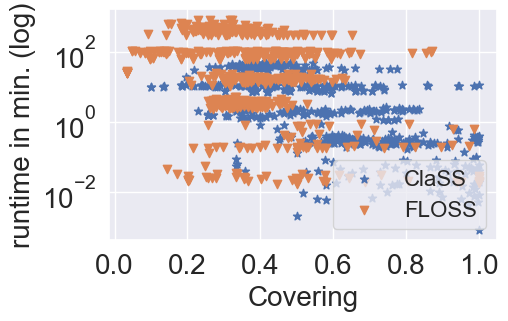

In [18]:
fontsize = 20

_, ax = plt.subplots(1, figsize=(5, 3))
ax.scatter(df_scores.ClaSS, df_runtimes.ClaSS / 60, label="ClaSS", marker="*")
ax.scatter(df_scores.FLOSS, df_runtimes.FLOSS / 60, label="FLOSS", marker="v")
ax.set_xlabel("Covering", fontsize=fontsize)
ax.set_ylabel("runtime in min. (log)", fontsize=fontsize)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(fontsize)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(fontsize)

ax.set_yscale('log')
ax.legend(loc=4, prop={'size': fontsize - 4})

plt.savefig(f"../figures/runtime_covering_scatter.pdf", bbox_inches="tight")

/var/folders/1m/8xt9fm8d1575s4p3vrgccf7r0000gn/T/ipykernel_1859/42937031.py:10: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(fontsize)
/var/folders/1m/8xt9fm8d1575s4p3vrgccf7r0000gn/T/ipykernel_1859/42937031.py:13: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(fontsize)


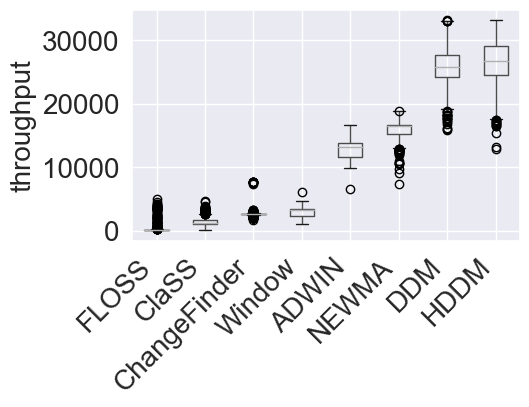

In [19]:
fontsize = 20
_, ax = plt.subplots(figsize=(5, 3))

order = ["FLOSS", "ClaSS", "ChangeFinder", "Window", "ADWIN", "NEWMA", "DDM", "HDDM"]

df_throughput[order].boxplot(ax=ax, rot=90)
ax.set_ylabel("throughput", fontsize=fontsize)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(fontsize)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(fontsize)

ax.set_xticklabels(order, rotation=45, ha="right")
plt.savefig(f"../figures/bp_throughput.pdf", bbox_inches="tight")